# import librairies

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# load data

In [102]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

shape test_image (28, 28)


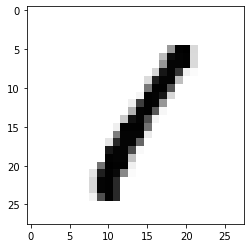

In [103]:
idx = 3  # label 1
test_image = x_train[idx]
print("shape test_image", np.shape(test_image))
plt.imshow(test_image, cmap='Greys')

# Compute bank of primers

In [124]:
def find_primer(image, filter, threshold=0.6, do_plot=False):
    filter = np.expand_dims(filter, axis=[2, 3])
    tf.convert_to_tensor(filter, dtype='float32')

    # convert image to tensor
    if len(np.shape(image)) == 2:
        image = np.expand_dims(image, axis=[0, 3])
    else:
        print("image shape is wrong! Expected 2 got ", len(np.shape(image)))
    image = tf.convert_to_tensor(image, dtype='float32')

    # apply convolution
    primers = tf.nn.conv2d(image, filter, strides=1, padding='VALID', name="conv1")

    # filters primers and discard the one under the threshold
    np_primers = primers.numpy()
    np_primers = np_primers[0, ..., 0]
    np_primers[np_primers < threshold] = 0
    #print("min max np_primers", np.min(np_primers), np.max(np_primers))

    # keep max value
    if np.sum(np_primers) != 0:
        primer_pos_x = np.argmax(np.amax(np_primers, axis=0))
        primer_pos_y = np.argmax(np.amax(np_primers, axis=1))

    else:
        primer_pos_x = None
        primer_pos_y = None

    if do_plot:
        # plot primers
        plt.figure()
        rgb_image = np.repeat(np.expand_dims(np_primers, axis=2), 3, axis=2)
        if primer_pos_x is not None and primer_pos_y is not None:
            rgb_image[primer_pos_y, primer_pos_x] = [1.0, 0, 0]
        plt.imshow(rgb_image)

    return (primer_pos_x, primer_pos_y)

In [122]:
# compute all primers
def find_primers(image, filters, do_plot=False):
    pos = []

    for p, pair_filt in enumerate(filters):
        prim0 = find_primer(image, pair_filt[0], do_plot=do_plot)
        prim1 = find_primer(image, pair_filt[1], do_plot=do_plot)
        print(prim0, prim1)

        # apply easy control of primers by discarding the ones that are contrary to their values
        # i.e. a horizontal line going left to right can not have a second primer that are more on the left than the first primer (p=1)
        append_pos = False
        if prim0[0] is not None and prim1[0] is not None:
            if p == 0:
                # vertical line
                if prim1[1] > prim0[1]:  # y1 > y0
                    append_pos = True
            elif p == 1:
                # horizontal line
               if prim1[0] > prim0[0]:  # x1 > x0
                    append_pos = True
            elif p == 2:
                # diag up line
               if prim1[0] > prim0[0] and prim0[1] > prim1[1]:  # x1 > x0 and y0 > y1
                    append_pos = True
            elif p == 3:
                # diag down line
               if prim1[0] > prim0[0] and prim1[1] > prim0[1]:  # x1 > x0 and y1 > y0
                    append_pos = True

        if append_pos:
            pos.append((prim0, prim1))
        else:
            pos.append(None)

    return pos

In [126]:
# find top primers for vertical lines
vert1 = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                  [-1., -1., -1., -1., -1., -1., -1.],
                  [-1., -1., -1., -1., -1., -1., -1.],
                  [-1., -1., 1.0, 1.0, 1.0, -1., -1.],
                  [-1., -1., 1.0, 1.0, 1.0, -1., -1.],
                  [-1., -1., 1.0, 1.0, 1.0, -1., -1.],
                  [-1., 0.0, 1.0, 1.0, 1.0, 0.0, -1.]])

vert2 = np.array([[-1., 0.0, 1.0, 1.0, 1.0, 0.0, -1.],
                  [-1., -1., 1.0, 1.0, 1.0, -1., -1.],
                  [-1., -1., 1.0, 1.0, 1.0, -1., -1.],
                  [-1., -1., 1.0, 1.0, 1.0, -1., -1.],
                  [-1., -1., -1., -1., -1., -1., -1.],
                  [-1., -1., -1., -1., -1., -1., -1.],
                  [-1., -1., -1., -1., -1., -1., -1.]])

hor1 = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                 [-1., -1., -1., -1., -1., -1., 0.0],
                 [-1., -1., -1., 1.0, 1.0, 1.0, 1.0],
                 [-1., -1., -1., 1.0, 1.0, 1.0, 1.0],
                 [-1., -1., -1., 1.0, 1.0, 1.0, 1.0],
                 [-1., -1., -1., -1., -1., -1., 0.0],
                 [-1., -1., -1., -1., -1., -1., -1.]])

hor2 = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                 [0.0, -1., -1., -1., -1., -1., -1.],
                 [1.0, 1.0, 1.0, 1.0, -1., -1., -1.],
                 [1.0, 1.0, 1.0, 1.0, -1., -1., -1.],
                 [1.0, 1.0, 1.0, 1.0, -1., -1., -1.],
                 [0.0, -1., -1., -1., -1., -1., -1.],
                 [-1., -1., -1., -1., -1., -1., -1.]])

diag_up1 = np.array([[-1., -1., -1., -1., 1.0, 1.0, 1.0],
                     [-1., -1., -1., 0.0, 1.0, 1.0, 1.0],
                     [-1., -1., -1., 1.0, 1.0, 1.0, 1.0],
                     [-1., -1., -1., 1.0, 1.0, 0.0, -1.],
                     [-1., -1., -1., -1., -1., -1., -1.],
                     [-1., -1., -1., -1., -1., -1., -1.],
                     [-1., -1., -1., -1., -1., -1., -1.]])

diag_up2 = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                     [-1., -1., -1., -1., -1., -1., -1.],
                     [-1., -1., -1., -1., -1., -1., -1.],
                     [-1., 0.0, 1.0, 1.0, -1., -1., -1.],
                     [1.0, 1.0, 1.0, 1.0, -1., -1., -1.],
                     [1.0, 1.0, 1.0, 0.0, -1., -1., -1.],
                     [1.0, 1.0, 1.0, -1., -1., -1., -1.]])

diag_down1 = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                       [-1., -1., -1., -1., -1., -1., -1.],
                       [-1., -1., -1., -1., -1., -1., -1.],
                       [-1., -1., -1., 1.0, 1.0, 0.0, -1.],
                       [-1., -1., -1., 1.0, 1.0, 1.0, 1.0],
                       [-1., -1., -1., 0.0, 1.0, 1.0, 1.0],
                       [-1., -1., -1., -1., 1.0, 1.0, 1.0]])

diag_down2 = np.array([[1.0, 1.0, 1.0, -1., -1., -1., -1.],
                       [1.0, 1.0, 1.0, 0.0, -1., -1., -1.],
                       [1.0, 1.0, 1.0, 1.0, -1., -1., -1.],
                       [-1., 0.0, 1.0, 1.0, -1., -1., -1.],
                       [-1., -1., -1., -1., -1., -1., -1.],
                       [-1., -1., -1., -1., -1., -1., -1.],
                       [-1., -1., -1., -1., -1., -1., -1.]])

primers = np.array([[vert1, vert2],
                    [hor1, hor2],
                    [diag_up1, diag_up2],
                    [diag_down1, diag_down2]])
print("shape primers", np.shape(primers))

# normalize input and filters
test_image_norm = test_image / 255.
primers_norm = primers / 12
primer_top_pos = find_primers(test_image_norm, primers_norm, do_plot=False)
print("primer_top_pos", primer_top_pos)

shape primers (4, 2, 7, 7)
(16, 2) (7, 21)
(None, None) (None, None)
(5, 21) (17, 2)
(14, 1) (9, 21)
primer_top_pos [((16, 2), (7, 21)), None, ((5, 21), (17, 2)), None]


In [ ]:
# plot found vectors
